In [3]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import h5py
from PIL import Image
from io import BytesIO


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(False) # Needed for reproducible results

/data1/home/nidhi2023/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Seed:  999


In [4]:
# !kaggle competitions download -c isic-2024-challenge

In [5]:
# Setup device-agnostic code
device = "cuda:1" if torch.cuda.is_available() else "cpu"
device

'cuda:1'

In [6]:
train_matadata = pd.read_csv("../wgangp/train-metadata.csv", low_memory=False)
train_matadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [10]:
class ImageLoader(Dataset):
    def __init__(self, df, file_hdf, transform=None):
        self.df = df
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.targets = df['target'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        # print(isic_id)
        image = Image.open(BytesIO(self.fp_hdf[isic_id][()]))
        target = self.targets[index]
#         image = torch.permute(image,(2,1,0))
        if self.transform:
            return (self.transform(image)),target
        else:
            return (image),target

In [34]:
class ImageLoader_pos(Dataset):
    def __init__(self, df, file_hdf, transform=None):
        self.df = df
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df[df['target']==1]['isic_id'].values
#         self.targets = df['target'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        # print(isic_id)
        image = Image.open(BytesIO(self.fp_hdf[isic_id][()]))
#         target = self.targets[index]
#         image = torch.permute(image,(2,1,0))
        if self.transform:
            return (self.transform(image))
        else:
            return (image)

In [13]:
train_transforms = transforms.Compose([
                               transforms.Resize(128),
                               transforms.CenterCrop(128),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

train_dataset = ImageLoader(train_matadata,
                      file_hdf = "../wgangp/train-image.hdf5",
                      transform=train_transforms
                     )

In [36]:
len(positive_dataset_full)

393

In [14]:
len(train_dataset)

401059

In [38]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model.eval()

Using cache found in /data1/home/nidhi2023/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [155]:
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
print(newmodel)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [40]:
dataloader = torch.utils.data.DataLoader(train_dataset_full, batch_size=512,num_workers=4,shuffle=True)
pos_dataloader = torch.utils.data.DataLoader(positive_dataset_full, batch_size=512,num_workers=4)

# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

ds = iter(dataloader)


# next(ds).shape

In [41]:
if torch.cuda.is_available():
    model.to('cuda:6')
    print('device','cuda')
    

device cuda


In [42]:
len(dataloader)

783

In [43]:
len(pos_dataloader)

1

In [44]:
import tqdm

In [156]:
out = []
pos_out = []
model.eval()
for p in model.parameters():
        p.requires_grad = False
with torch.no_grad():
    for imgs in tqdm.tqdm(dataloader) :
        
        imgs = imgs.to('cuda:6')
        y = newmodel(imgs)
        out.append(y.cpu().detach().numpy())
    
    for imgs in tqdm.tqdm(pos_dataloader) :
        
        imgs = imgs.to('cuda:6')
        y = newmodel(imgs)
        pos_out.append(y.cpu().detach().numpy())

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


In [160]:
out = np.concatenate( out, axis=0 ).reshape(-1,512)
pos_out = np.concatenate( pos_out, axis=0 ).reshape(-1,512)

In [161]:
print(out.shape,pos_out.shape)

(400666, 512) (393, 512)


In [214]:
np.append([0]*50000,[1]*300).shape

(50300,)

In [208]:
np.vstack((out[:50000],pos_out)).shape

(50393, 512)

In [230]:
from sklearn.svm import SVC
clf1 = SVC(class_weight={1: 100},probability=True).fit(np.vstack((out[:50000],pos_out[:300])),np.append([0]*50000,[1]*300))

In [231]:
x_pred = np.vstack((out[50000:100000],pos_out[300:]))
y_true = np.append([0]*50000,[1]*93)
y_pred = clf1.predict_proba(x_pred)

In [232]:
y_true.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [233]:
with open('svm_classify_512resnet_binary.pkl','wb') as f:
    pickle.dump(clf,f)

/data1/home/nidhi2023/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


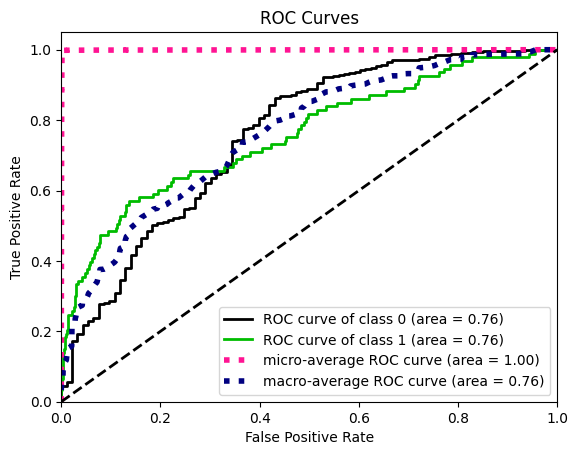

In [235]:
# y_pred_pobab = np.vstack((1-y_pred,y_pred)).T
skplt.metrics.plot_roc_curve(y_true, y_pred)
plt.show()

In [162]:
import pickle
import pandas as pd
import pandas.api.types
from sklearn.metrics import roc_curve, auc, roc_auc_score
import scikitplot as skplt
import matplotlib.pyplot as plt

clf = OneClassSVM(gamma='auto').fit(out[:50000])


In [163]:
with open('svm_classify_512resnet.pkl','wb') as f:
    pickle.dump(clf,f)

In [164]:

class_out = clf.decision_function(out[50000:100000])
pos_class_out = clf.decision_function(pos_out)

In [168]:
maxx = max(class_out.max(),pos_class_out.max())
class_out = -1*class_out/maxx
pos_class_out = -1*pos_class_out/maxx

In [170]:
minn = min(class_out.min(),pos_class_out.min())
class_out = class_out-minn
pos_class_out = pos_class_out-minn

In [172]:
maxx = max(class_out.max(),pos_class_out.max())
class_out = class_out/maxx
pos_class_out = pos_class_out/maxx

In [204]:
(pos_class_out>0.055).sum()/393

0.8091603053435115

In [205]:
(class_out>0.055).sum()/50000

0.6834

In [174]:
y_true = np.append([1]*393,[0]*50000)
y_pred = np.append(pos_class_out,class_out)

In [175]:
import sklearn

In [236]:
import numpy as np


class ParticipantVisibleError(Exception):
    pass


def score(solution, submission, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC
    
    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC) 
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.
    
    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''

    # # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    # v_gt = abs(np.asarray(solution)-1)
    
    # # flip the submissions to their compliments
    # v_pred = -1.0*np.asarray(submission)

    # max_fpr = abs(1-min_tpr)

    # # using sklearn.metric functions: (1) roc_curve and (2) auc
    # fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    # if max_fpr is None or max_fpr == 1:
    #     return auc(fpr, tpr)
    # if max_fpr <= 0 or max_fpr > 1:
    #     raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # # Add a single point at max_fpr by linear interpolation
    # stop = np.searchsorted(fpr, max_fpr, "right")
    # x_interp = [fpr[stop - 1], fpr[stop]]
    # y_interp = [tpr[stop - 1], tpr[stop]]
    # tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    # fpr = np.append(fpr[:stop], max_fpr)
    # partial_auc = auc(fpr, tpr)

    # Equivalent code that uses sklearn's roc_auc_score
    v_gt = abs(np.asarray(solution)-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return(partial_auc)

In [240]:
y_pred[:,1].shape

(50093,)

In [241]:
score(y_true,y_pred[:,1])

0.060709376344085984

In [188]:
roc_auc_score(y_true, y_pred)

0.6506602544529262

In [220]:
print(sklearn.metrics.classification_report(y_true, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [1, 50093]

In [183]:
np.vstack((y_pred,1-y_pred)).T

array([[0.37358949, 0.62641051],
       [0.10463337, 0.89536663],
       [0.35409976, 0.64590024],
       ...,
       [0.05424644, 0.94575356],
       [0.04548167, 0.95451833],
       [0.08269325, 0.91730675]])

In [186]:
y_pred_pobab = np.vstack((1-y_pred,y_pred)).T

/data1/home/nidhi2023/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


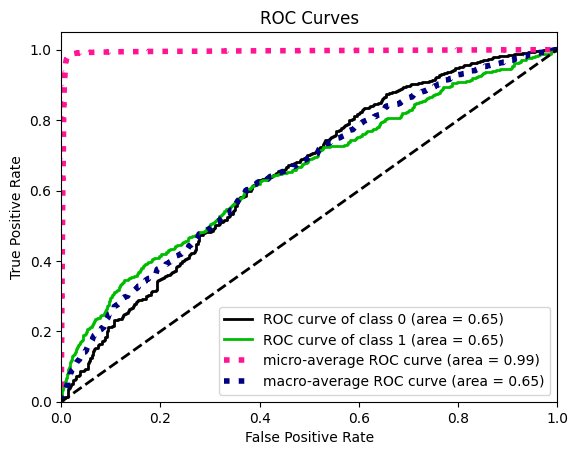

In [187]:


# y_true = # ground truth labels
# y_probas = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_pred_pobab)
plt.show()

In [132]:
(class_out>5400).sum()#/len(class_out)

25258

In [57]:
print( (pos_class_out==-1).sum() , (pos_class_out==1).sum() )

272 121


In [58]:
print( (class_out==-1).sum() , (class_out==1).sum() )

24831 25169


In [53]:
class_out.sum()

338

In [54]:
a.sum()

28

In [1]:


with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
print(output[0])

SyntaxError: invalid syntax (533705004.py, line 1)